# Predicting attendances next year 

## Overview 

This notebook contains the code to train the MGSR on data from 2018 and forecast ED demand for 2019.

The performance of the MGSR is assessed using the mean absolute percentage error (MAPE).


In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]])
               if '/' in c else c for c in dta.columns]

In [5]:
dta.head()

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives,year
0,00Q,Jan,406.655830,308.945095,310.561801,234.716187,4568.019766,1179.855246,14.8942,97.2,99.7,94.4,2018
1,00Q,Feb,349.933603,256.872981,261.756435,205.298797,3910.918344,1075.452189,14.8942,97.2,99.7,94.4,2018
2,00Q,Mar,413.247659,300.690725,303.676215,234.716187,4051.778545,1210.874032,14.8942,97.2,99.7,94.4,2018
3,00Q,Apr,349.608595,278.140171,264.973181,203.677924,3974.433001,1186.166427,14.8942,97.2,99.7,94.4,2018
4,00Q,May,361.100544,284.419492,294.361403,227.926437,4232.385761,1299.297713,14.8942,97.2,99.7,94.4,2018


In [6]:
dta.shape

(1618, 13)

## Function to group data 

In [7]:
def group_data(data, features):

    features = ['population',
                'People', 'Places',
                'Lives']


    #ensure no identical points in train and test

    grouped = pd.DataFrame()
    
    for pop, group in data.groupby('population'):

        #if len(group.lives.unique())>1:

            #print('multiple CCG with same population')

        ccg_year = pd.Series(dtype='float64')

        for f in features:

            ccg_year[f] = group[f].unique()[0]

        ccg_year['ae_attendances_attendances']\
        = group.ae_attendances_attendances.mean()
        

        grouped = grouped.append(ccg_year, ignore_index=True)
        
    return grouped

In [8]:
def fit_capacity(dta, features, model):
    
    y = dta['ae_attendances_attendances']
    X = dta[features]

    model.fit(X,y)
    
    return model

In [9]:
def fit_final(dta, rf1, rf2, m1_features, m2_features):
    
    
    final = LinearRegression()


    #train capactiy model
    
    rf1 = fit_capacity(dta, m1_features, rf1)
    

    #predict monthly attendances

    y_pred_1 = rf1.predict(dta[m1_features])

    
    
    grouped = group_data(dta, m2_features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[m2_features]

    rf2.fit(X, y)
    
    y_pred_2 = rf2.predict(dta[m2_features])
        
        
    X_f = np.vstack([y_pred_1, y_pred_2]).T
    y_f = dta['ae_attendances_attendances']

    final.fit(X_f,y_f)

    print('Combined training score:',final.score(X_f,y_f))
    
    return rf1,rf2, final        

In [10]:
#capacity utility
capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

pophealth_features = ['population',
                    'People', 'Places', 'Lives']

## Split data 

In [11]:
train = dta.loc[dta.year==2018]

In [12]:
test = dta.loc[dta.year==2019]

## Fit to 2018 

In [13]:
#capacity model
rf1 = RandomForestRegressor(max_depth=5, n_estimators=6, random_state=0)

#population health model
rf2 = RandomForestRegressor(max_depth=5, n_estimators=4, random_state=0)

In [14]:
m1_features = capacity_features
m2_features = pophealth_features

rf1,rf2,final = fit_final(train, rf1, rf2, m1_features, m2_features)

Combined training score: 0.8665135886906001


## Predict on 2019 

In [15]:
def stacked_predict(X, models, m1_features, m2_features):
    
    rf1,rf2,final = models
    
    y_pred_1 = rf1.predict(X[m1_features])

    y_pred_2 = rf2.predict(X[m2_features])

    X_f = np.vstack([y_pred_1, y_pred_2]).T
    
    preds = final.predict(X_f)
    
    return preds

In [16]:
preds = stacked_predict(test, [rf1,rf2,final], m1_features, m2_features)

### MAPE

In [17]:
mape(test.ae_attendances_attendances.values,preds)

0.2539407129802637

### Plot 

In [18]:
test['preds'] = preds

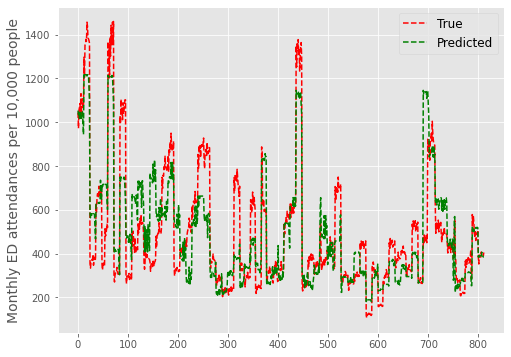

In [19]:
fig,ax = plt.subplots(figsize=(8,6))


plt.plot(test.ae_attendances_attendances.values, 'r--', label = 'True')
plt.plot(test.preds.values, 'g--', label = 'Predicted')

plt.ylabel('Monthly ED attendances per 10,000 people', fontsize=14)
plt.legend(loc='best', fontsize=12)

plt.show()

## Combine by month for total

In [20]:
res = pd.DataFrame()

months = ['Jan','Feb','Mar','Apr','May','Jun',\
              'Jul','Aug','Sep','Oct','Nov','Dec']

res['True'] = test.ae_attendances_attendances.values * test.population.values
res['Month'] = test.month.values
res['Pred'] = preds * test.population.values


true, pred = [],[]

for month in months:

    true.append(np.mean(res.loc[res.Month==month]['True'].values, axis=0))
    pred.append(np.mean(res.loc[res.Month==month]['Pred'].values, axis=0))

### MAPE 

In [21]:
mape(true, pred)

0.03857707492102586

### Plot 

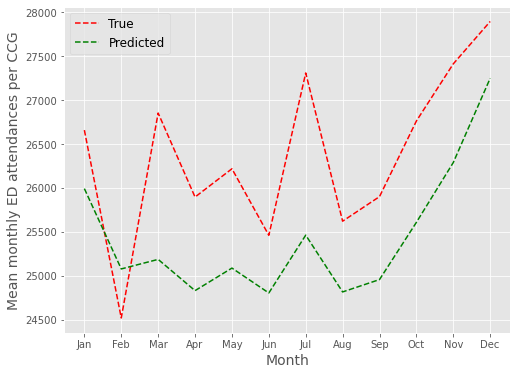

In [22]:
fig,ax = plt.subplots(figsize=(8,6))

plt.plot(months,true, 'r--', label = 'True')
plt.plot(months,pred, 'g--', label = 'Predicted')

plt.legend(loc='best', fontsize=12)

plt.ylabel('Mean monthly ED attendances per CCG', fontsize=14)
plt.xlabel('Month', fontsize=14)

plt.savefig('2019_forecast_mean.png')
plt.show()

## Figure for paper 

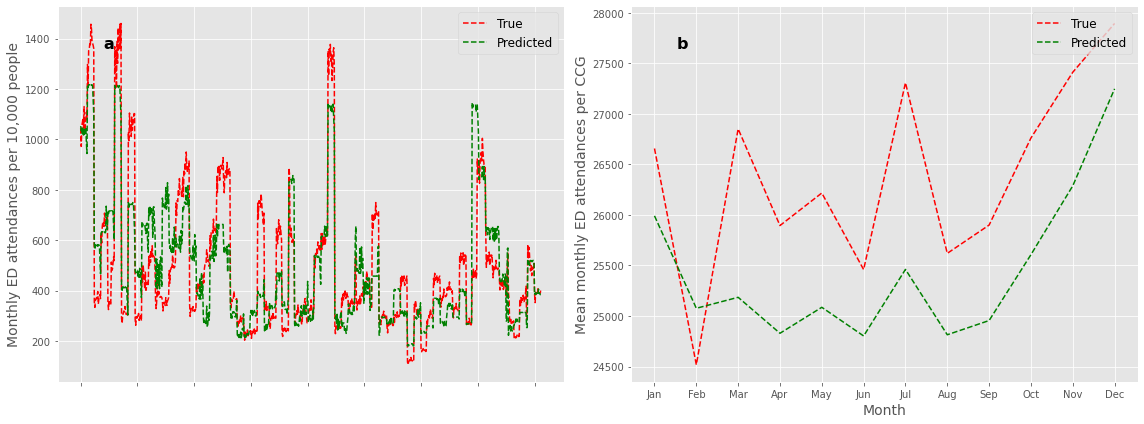

In [23]:
fig,ax_list = plt.subplots(1,2,figsize=(16,6))

ax=ax_list[0]

ax.plot(test.ae_attendances_attendances.values, 'r--', label = 'True')
ax.plot(test.preds.values, 'g--', label = 'Predicted')

ax.set_ylabel('Monthly ED attendances per 10,000 people', fontsize=14)
ax.legend(loc='best', fontsize=12)

ax.xaxis.set_ticklabels([])

ax.text(0.1, 0.9, 'a', horizontalalignment='center',
      verticalalignment='center', fontweight='bold',
        fontsize=16,transform=ax.transAxes)

ax=ax_list[1]

ax.plot(months,true, 'r--', label = 'True')
ax.plot(months,pred, 'g--', label = 'Predicted')

ax.legend(loc='upper right', fontsize=12)

ax.set_ylabel('Mean monthly ED attendances per CCG', fontsize=14)
ax.set_xlabel('Month', fontsize=14)

ax.text(0.1, 0.9, 'b', horizontalalignment='center',
      verticalalignment='center', fontweight='bold',
        fontsize=16,transform=ax.transAxes)

plt.tight_layout()

plt.savefig('2019_forecast.png')

plt.show()